Weather file found: /Users/petertunali/Documents/GitHub/Battery_Optimisation/data/Bonfire_2025.epw
Monthly shading factor setting not available in this version of PySAM
Added 40% shading loss to system losses
Total system losses including shading: 51%
Running PVWatts simulation...
Number of hourly values: 8760
Resampling to half-hourly intervals (no scaling)...
Saved half-hourly solar PV outputs to: /Users/petertunali/Documents/GitHub/Battery_Optimisation/outputs/taggerty_pv_baseline_2024.csv
Saved baseline parameters to: /Users/petertunali/Documents/GitHub/Battery_Optimisation/outputs/baseline_parameters.json

Total Annual Generation: 14824.41 kWh (14.82 MWh)
Capacity Factor: 16.92%
Average Daily Generation: 40.50 kWh/day

Monthly Generation (kWh):
January: 1851.34 kWh
February: 1548.74 kWh
March: 1420.11 kWh
April: 1028.21 kWh
May: 714.58 kWh
June: 599.61 kWh
July: 726.56 kWh
August: 896.99 kWh
September: 1166.73 kWh
October: 1486.85 kWh
November: 1647.48 kWh
December: 1737.22 kWh
Sa

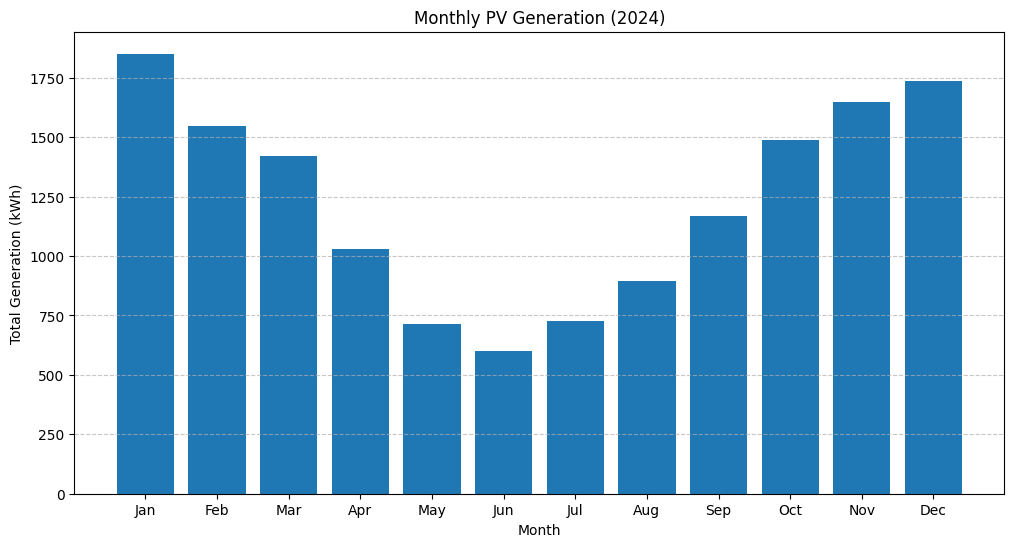

In [15]:
import PySAM.Pvwattsv8 as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import json

# Define paths relative to the notebook
project_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
weather_file_path = os.path.join(project_dir, "data", "Bonfire_2025.epw")

# Check if weather file exists
if not os.path.exists(weather_file_path):
    print(f"Warning: Weather file not found at {weather_file_path}")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Project directory: {project_dir}")
    
    alternatives = [
        os.path.join(project_dir, "data", "Bonfire-2025.epw"),
        os.path.join(project_dir, "data", "bonfire_2025.epw"),
        os.path.join(project_dir, "data", "bonfire-2025.epw"),
        os.path.join(project_dir, "data", "Bonfire.epw")
    ]
    for alt_path in alternatives:
        if os.path.exists(alt_path):
            weather_file_path = alt_path
            print(f"Found alternative weather file at: {weather_file_path}")
            break
    data_dir = os.path.join(project_dir, "data")
    if os.path.exists(data_dir):
        print("\nFiles in data directory:")
        for file in os.listdir(data_dir):
            if file.endswith('.epw'):
                print(f"- {file}")
else:
    print(f"Weather file found: {weather_file_path}")

# Create a PV system model
pv_system = pv.default("PVWattsNone")

# Set the weather file
pv_system.SolarResource.solar_resource_file = weather_file_path

# System specifications
pv_system.SystemDesign.system_capacity = 10
pv_system.SystemDesign.dc_ac_ratio = 1.2
pv_system.SystemDesign.inv_eff = 96
pv_system.SystemDesign.tilt = 10
pv_system.SystemDesign.azimuth = 18
pv_system.SystemDesign.module_type = 0
pv_system.SystemDesign.array_type = 0

# Try to apply monthly shading factors
try:
    monthly_shading = [0.70, 0.70, 0.68, 0.60, 0.60, 0.55, 0.55, 0.60, 0.60, 0.65, 0.68, 0.70]
    pv_system.SolarResource.shading_factor_beam = monthly_shading
    print("Applied monthly shading factors (initial guess):", monthly_shading)
    # Flag to indicate if we need to apply shading losses separately
    shading_applied = True
except AttributeError:
    print("Monthly shading factor setting not available in this version of PySAM")
    # Flag to indicate we need to account for shading in system losses
    shading_applied = False

# Define individual losses
soiling_loss = 5  # %
wiring_loss = 2  # %
inverter_loss = 3  # %
degradation_loss = 1  # %
shading_loss = 40  # % (high value to account for significant shading)

# Sum total losses
if shading_applied:
    total_system_losses = soiling_loss + wiring_loss + inverter_loss + degradation_loss
    print(f"Using monthly shading factors, other system losses set to: {total_system_losses}%")
else:
    total_system_losses = soiling_loss + wiring_loss + inverter_loss + degradation_loss + shading_loss
    print(f"Added {shading_loss}% shading loss to system losses")
    print(f"Total system losses including shading: {total_system_losses}%")

pv_system.SystemDesign.losses = total_system_losses

# Run the simulation
print("Running PVWatts simulation...")
pv_system.execute()

# Correction: PySAM gives AC output in Watts, convert to kW
ac_output = np.array(pv_system.Outputs.ac) / 1000

# Confirm length
print(f"Number of hourly values: {len(ac_output)}")

# Build hourly DataFrame
start_date = datetime(2024, 1, 1, 0, 0)
hours = [start_date + timedelta(hours=i) for i in range(len(ac_output))]
hourly_results = pd.DataFrame({
    'datetime': hours,
    'ac_output_kwh': ac_output
})

# Set datetime as index
hourly_results.set_index('datetime', inplace=True)

# Resample to half-hourly intervals
print("Resampling to half-hourly intervals (no scaling)...")
half_hourly_results = hourly_results.resample("30min").interpolate(method='linear')

# Shift timestamps to end of interval
half_hourly_results = half_hourly_results.shift(periods=1, freq='30min')
half_hourly_results.reset_index(inplace=True)

# Add columns
half_hourly_results['PV_Generation_Actual (kWh)'] = half_hourly_results['ac_output_kwh']
half_hourly_results['month'] = half_hourly_results['datetime'].dt.month
half_hourly_results['day'] = half_hourly_results['datetime'].dt.day
half_hourly_results['hour'] = half_hourly_results['datetime'].dt.hour
half_hourly_results['minute'] = half_hourly_results['datetime'].dt.minute

# Output directory
output_dir = os.path.join(project_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)

# Save CSV
output_file = os.path.join(output_dir, "taggerty_pv_baseline_2024.csv")
half_hourly_results.to_csv(output_file, index=False)
print(f"Saved half-hourly solar PV outputs to: {output_file}")

# Save parameters
params = {
    'system_capacity': 10,
    'dc_ac_ratio': 1.2,
    'inv_eff': 96,
    'losses': total_system_losses,
    'tilt': 10,
    'azimuth': 18,
    'module_type': 0,
    'array_type': 0,
    'monthly_shading': monthly_shading if shading_applied else "Applied as system loss",
    'output_column': 'PV_Generation_Actual (kWh)',
    'export_limit': None,
    'leap_year': True
}
params_file = os.path.join(output_dir, "baseline_parameters.json")
with open(params_file, 'w') as f:
    json.dump(params, f, indent=4)
print(f"Saved baseline parameters to: {params_file}")

# Annual summary
annual_energy_kwh = half_hourly_results['PV_Generation_Actual (kWh)'].sum()
annual_energy_mwh = annual_energy_kwh / 1000
capacity_factor = annual_energy_kwh / (10 * 8760) * 100

print(f"\nTotal Annual Generation: {annual_energy_kwh:.2f} kWh ({annual_energy_mwh:.2f} MWh)")
print(f"Capacity Factor: {capacity_factor:.2f}%")
print(f"Average Daily Generation: {annual_energy_kwh/366:.2f} kWh/day")

# Sanity check
if annual_energy_kwh > 25000:
    print("\n⚠️ Warning: Annual energy seems too high for 10 kW system. Check system settings!")

# Monthly summary
monthly_generation = half_hourly_results.groupby('month')['PV_Generation_Actual (kWh)'].sum()
print("\nMonthly Generation (kWh):")
for month, generation in monthly_generation.items():
    month_name = datetime(2024, month, 1).strftime('%B')
    print(f"{month_name}: {generation:.2f} kWh")

# Plot monthly generation
plt.figure(figsize=(12, 6))
months = range(1, 13)
monthly_values = [monthly_generation.get(m, 0) for m in months]
plt.bar(months, monthly_values)
plt.xlabel('Month')
plt.ylabel('Total Generation (kWh)')
plt.title('Monthly PV Generation (2024)')
plt.xticks(months, [datetime(2024, m, 1).strftime('%b') for m in months])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plot_file = os.path.join(output_dir, "monthly_generation_2024.png")
plt.savefig(plot_file)
print(f"Saved monthly generation plot to: {plot_file}")

print("\nBaseline simulation complete!")